# Imports and file loading

In [93]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import csv
import numpy as np
from event import Event

In [94]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    f.close()
    return i + 1

def open_full_atf_file(file_name):
    file_length=file_len(file_name)
    file_handle=open(directory+file_name, 'r')
    csv_reader = csv.reader(file_handle, delimiter='\t', quotechar='|')
    data=np.empty((file_length,2))
    i=0
    for row in csv_reader:
        data[i,0]=row[0]
        data[i,1]=row[1]
        i+=1
    
    return data


def open_raw_file(file_name, data_point_start=-1, data_point_end=-1):
    # open full file
    if data_point_start == -1:
        data_point_start=0
    if data_point_end == -1:
        data_point_end=file_len(file_name)
    print data_point_end
    
    data=np.empty((data_point_end-data_point_start,2))
        
    file_handle=open(file_name, 'r')
    csv_reader = csv.reader(file_handle, delimiter='\t', quotechar='|')
    
    for i in range(0, data_point_start):
        row=csv_reader.next()
    
    for i in range(0, data_point_end-data_point_start):
        row=csv_reader.next()
        try:
            data[i,0]=row[0]
            data[i,1]=row[1]
        except:
            continue
            
    file_handle.close()
    
    return data

# Preliminary

In [95]:
# File info
directory='./data/'
file_name='Chip4_HCT116_0021_0.005'
file_length=file_len(directory+file_name)
print file_length/250000.

491.5


In [81]:
# Define search parameters
interval=10000000

baseline_avg_length=100    # was 200
event_avg_length=3 # was 5
trigger_sigma_threshold=5
max_search_length=1000

event_indices=np.empty((0,2),dtype=int)
baseline=np.empty((0,4), dtype=float)

In [82]:
i=0
start=0
stop=interval
data=open_raw_file(directory+file_name, start, stop)

10000000


In [83]:
baseline_avg_length=200    # was 200
event_avg_length=5
trigger_sigma_threshold=6
max_search_length=1000
baseline=np.empty((0,4))

current_index=0
while current_index+baseline_avg_length <= data.shape[0]:
    baseline_avg=np.mean(data[current_index:current_index+baseline_avg_length,1])
    baseline_sigma=np.std(data[current_index:current_index+baseline_avg_length,1])
    baseline=np.vstack((baseline, [[data[current_index,0], baseline_avg,\
                                    baseline_avg-1.*trigger_sigma_threshold*baseline_sigma,\
                                    baseline_avg+1.*trigger_sigma_threshold*baseline_sigma]]))
    current_index+=baseline_avg_length

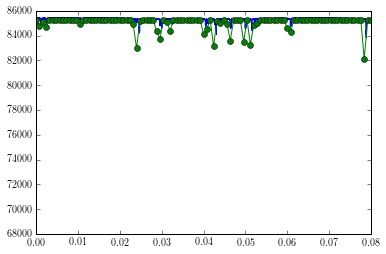

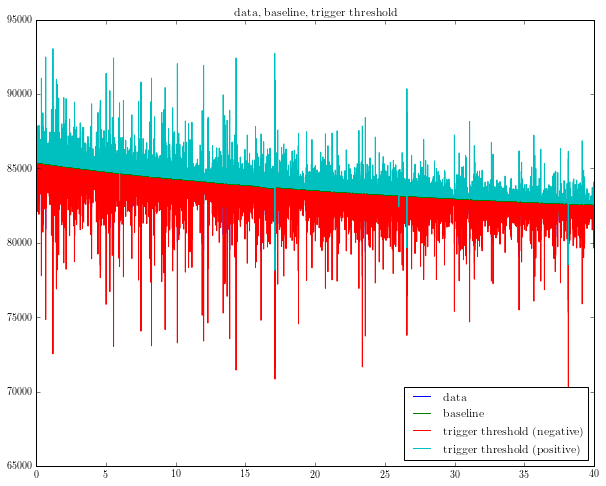

In [84]:
# Plot current over interval used to calculate the baseline
'''
plt.plot(data[:baseline_avg_length,0], data[:baseline_avg_length,1])

plt.title('baseline interval')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('time (s)')
plt.ylabel('current')

plt.show()
'''

# Plot close up
a=0
b=20000
plt.plot(data[a:b,0], data[a:b,1])
#plt.plot(baseline[a:b,0], baseline[:,1], label='baseline')
plt.plot(baseline[:,0], baseline[:,2], label='trigger threshold (negative)', marker='o')
#plt.plot(baseline[a:b,0], baseline[:,3], label='trigger threshold (positive)')
plt.xlim(data[a,0],data[b,0])
plt.show()

# Plot baseline and trigger value
fig=plt.figure(figsize=(10,8))
plt.plot(data[:,0], data[:,1], label='data')
plt.plot(baseline[:,0], baseline[:,1], label='baseline')
plt.plot(baseline[:,0], baseline[:,2], label='trigger threshold (negative)')
plt.plot(baseline[:,0], baseline[:,3], label='trigger threshold (positive)')

plt.xlim(data[0,0], data[-1,0])

plt.legend(loc='lower right')

plt.title('data, baseline, trigger threshold')
plt.show()

# Begin file scan

In [85]:
### baseline=np.empty((0,4), dtype=float)
event_indices=np.empty((0,2),dtype=int)

events=[]

i=0
file_finished=False

baseline=np.empty((0,4))
i=0
while i < 1:#file_len(directory+file_name)/interval:
    # Load next interval
    print 'i=',i
    start=1000+i*interval
    stop=start+interval
    if stop+interval > file_length:
        stop=file_length
        file_finished = True
    data=open_raw_file(directory+file_name, start, stop)
    i+=1
    
    
    try:
        current_index=0
        baseline_avg=np.mean(data[current_index:current_index+baseline_avg_length,1])
        baseline_sigma=np.std(data[current_index:current_index+baseline_avg_length,1])
        trigger_threshold=trigger_sigma_threshold*baseline_sigma
        baseline=np.vstack((baseline, np.array([[data[current_index,0], baseline_avg, baseline_avg-trigger_threshold,\
                                           baseline_avg+trigger_threshold]], dtype=float)))
        while True:
            # Look for events
            start_trigger_found = False
            while start_trigger_found == False:
                # Current exceeds trigger threshold
                if abs(data[current_index,1]-baseline_avg) >= trigger_threshold:
                    # Check to see which updated baseline to compare to
                    # Update baseline (i.e. in case of drift)
                    baseline_avg=np.mean(data[current_index-2*baseline_avg_length:current_index-baseline_avg_length,1])
                    baseline_sigma=np.std(data[current_index-2*baseline_avg_length:current_index-baseline_avg_length,1])
                    trigger_threshold=trigger_sigma_threshold*baseline_sigma
                    baseline=np.vstack((baseline, np.array([[data[current_index,0], baseline_avg, baseline_avg-1.*trigger_threshold,\
                                                baseline_avg+1.*trigger_threshold]], dtype=float)))
                            
                    # Point still exceeds trigger threshold
                    if abs(data[current_index,1]-baseline_avg) >= trigger_threshold:
                        # Trigger, get first point to exit baseline
                        event_avg=np.mean(data[current_index-event_avg_length:current_index,1])
                        start_index=current_index
                        
                        reentry_threshold=(baseline_avg+baseline_avg-trigger_threshold)/2.
                        while start_trigger_found == False:
                            if abs(data[start_index,1])>=abs(reentry_threshold):
                                print 'event #', event_indices.shape[0]
                                start_trigger_found = True
                            else:
                                event_avg=np.mean(data[start_index-event_avg_length:start_index,1])
                                start_index-=1
                    else:
                        continue
                current_index+=1
    
    
            # Look for possible event end
            stop_trigger_found = False
            while stop_trigger_found == False: 
                
                # Check if in baseline
                in_baseline=True
                for l in range(10):
                    if abs(data[current_index+l,1]-baseline_avg) >= trigger_threshold: 
                        in_baseline=False
                
                # Return to baseline
                if in_baseline:
                    stop_index=current_index
                    
                    # Find exact event end
                    event_avg=np.mean(data[current_index:current_index+event_avg_length,1])
                    
                    # Trigger, find first point to re-enter baseline
                    reentry_threshold=(baseline_avg+baseline_avg-trigger_threshold)/2.
                    while stop_trigger_found == False:
                        if abs(data[stop_index,1])>=abs(reentry_threshold):
                            stop_trigger_found = True
                        else:
                            stop_index+=1
                    
                    current_index=stop_index
                    event_indices=np.vstack((event_indices, [[start_index, stop_index+1]]))
                        
                    events.append(Event())
                    new_event=events[-1]
                    new_event.set_start_stop_index(1.*event_indices[-1,0], 1.*event_indices[-1,1])
                    new_event.set_data(data[event_indices[-1,0]:event_indices[-1,1],:])
                    new_event.set_baseline_avg(baseline_avg)
                        
                    data[start_index:stop_index,1]=data[start_index-(stop_index-start_index):start_index,1]
    
                # Maximum search length
                if current_index-start_index >= max_search_length:
                    print 'hit maximum search length...\n'
                    print '\tcurrent_index=', current_index, 'start_index=', start_index, '\n'
                    stop_trigger_found = True
                    current_index=start_index+max_search_length #remove max search length
                    baseline_avg=np.mean(data[current_index:current_index+baseline_avg_length,1])
                    baseline_sigma=np.std(data[current_index:current_index+baseline_avg_length,1])
                    trigger_threshold=trigger_sigma_threshold*baseline_sigma
                    baseline=np.vstack((baseline, np.array([[data[current_index,0], baseline_avg, baseline_avg-1.*trigger_threshold,\
                                                   baseline_avg+1.*trigger_threshold]], dtype=float)))       
                    
                current_index+=1
                #print '\tt=', data[event_indices[-1,0],0]
                #print '\t', event_indices[-1,0], event_indices[-1,1], event_indices[-1,1]-event_indices[-1,0]
    except:
        continue

i= 0
10001000
event # 0
event # 1
event # 2
event # 3
event # 4
event # 5
event # 6
event # 7
event # 8
event # 9
event # 10
event # 11
event # 12
event # 13
event # 14
event # 15
event # 16
event # 17
event # 18
event # 19
event # 20
event # 21
event # 22
event # 23
event # 24
event # 25
event # 26
event # 27
event # 28
event # 29
event # 30
event # 31
event # 32
event # 33
event # 34
event # 35
event # 36
event # 37
event # 38
event # 39
event # 40
event # 41
event # 42
event # 43
event # 44
event # 45
event # 46
event # 47
event # 48
event # 49
event # 50
event # 51
event # 52
event # 53
event # 54
event # 55
event # 56
event # 57
event # 58
event # 59
event # 60
event # 61
event # 62
event # 63
event # 64
event # 65
event # 66
event # 67
event # 68
event # 69
event # 70
event # 71
event # 72
event # 73
event # 74
event # 75
event # 76
event # 77
event # 78
event # 79
event # 80
event # 81
event # 82
event # 83
event # 84
event # 85
event # 86
event # 87
event # 88
event # 89
event 

# Post-process events

## Filter short events

In [86]:
length_threshold=50

events_length_before=len(events)
events=[event for event in events if event._data.shape[0] >= 50]
events_length_after=len(events)

print events_length_before, events_length_after

5085 4463


## Calculate amplitudes

In [87]:
for event in events:
    event.calculate_amplitude()

## Find extrema

In [88]:
def get_maxima_minima(data):
    # Calculate first derivatives everywhere
    d_data=[((data[(i+1)%len(data)]-data[i])+(data[i]-data[i-1]))/2. for i in range(len(data))]
    
    # Find derivative = 0
    maxima=[]
    minima=[]
    
    #d2_maxima=np.empty((0,2))
    #d2_minima=np.empty((0,2))
    
    derivative_sign=1*int(data[1]>data[0])-1*int(data[1]<=data[0])
    for i in range(data.shape[0]-1):
        new_derivative_sign=1*int(data[i+1]>data[i])-1*int(data[i+1]<=data[i])
        if new_derivative_sign != derivative_sign:
            # Found derivative = 0, calculate 2nd derivative to see if min/max
            d2=((d_data[(i+1)%len(d_data)]-d_data[i])+(d_data[i]-d_data[i-1]))/2.
            if d2<=0:
                maxima.append(i)
                #d2_maxima=np.vstack((d2_maxima, np.array([[i, d2]])))
            else:
                minima.append(i)
                #d2_minima=np.vstack((d2_minima, np.array([[i, d2]])))
        derivative_sign=new_derivative_sign
        
    
    #d2_maxima=np.flipud(d2_maxima[np.argsort(d2_maxima[:,1])])
    #max_cnt=2*int(d2_maxima.shape[0]>=2) + d2_maxima.shape[0]*int(d2_maxima.shape[0]<2)
    #for i in range(max_cnt):
#        maxima.append(int(d2_maxima[i,0]))
    
#    d2_minima=np.flipud(d2_minima[np.argsort(d2_minima[:,1])])
#    min_cnt=3*int(d2_minima.shape[0]>=3) + d2_minima.shape[0]*int(d2_minima.shape[0]<3)
#    for i in range(min_cnt):
#        minima.append(int(d2_minima[i,0]))
                
    maxima.sort()
    minima.sort()
            
    return maxima, minima

In [89]:
from scipy.ndimage.filters import gaussian_filter
for event in events:
    event.set_smoothed_data(gaussian_filter(event._data[:,1], sigma=event._data.shape[0]/30.))
    maxima, minima=get_maxima_minima(event._smoothed_data)
    event.set_maxima(maxima)
    event.set_minima(minima)
    event.set_extrema(maxima, minima)

### Refine extrema

In [90]:
for event in events: 
    for i in range(len(event._maxima)):
        maxima=event._maxima[i]
        if event._data[maxima+1,1] > event._data[maxima,1]:
            event._maxima[i]=maxima+1
        elif event._data[maxima-1,1] > event._data[maxima,1]:
            event._maxima[i]=maxima-1
            
            
    for i in range(len(event._minima)):
        minima=event._minima[i]
        if event._data[minima+1,1] < event._data[minima,1]:
            event._minima[i]=minima+1
        elif event._data[minima-1,1] < event._data[minima,1]:
            event._minima[i]=minima-1
            
    event.set_extrema(event._minima, event._maxima)

### Remove non-conforming events

In [91]:
events_length_before=len(events)
events=[event for event in events if len(event._extrema) == 5]
events_length_after=len(events)
print events_length_after, events_length_before

3984 4463


# Make plots

## Plot 100 events

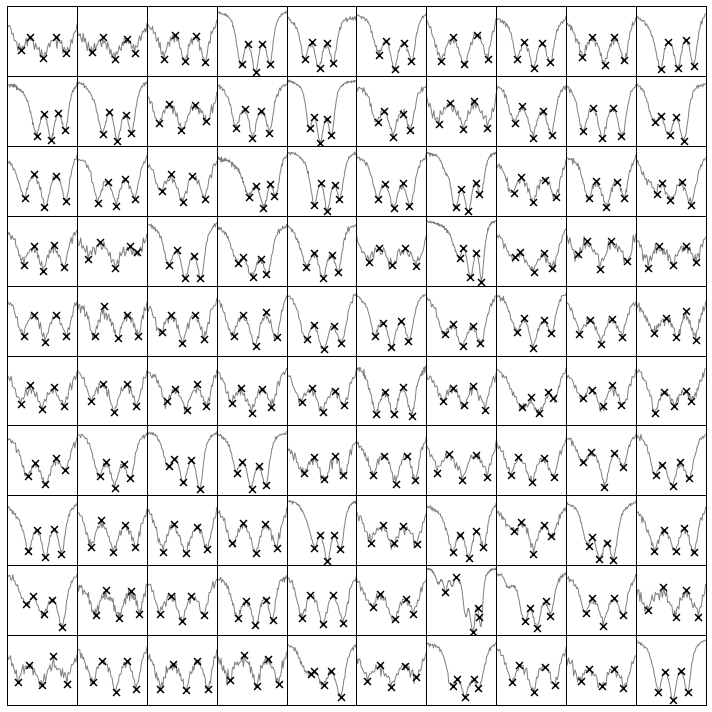

In [92]:
fig=plt.figure(figsize=(10,10))
gs=gridspec.GridSpec(10,10)
gs.update(wspace=0, hspace=0)
for i in range(100):
    plt.subplot(gs[i])
    f1=plt.gca()
    f1.axes.get_xaxis().set_ticks([])
    f1.axes.get_yaxis().set_ticks([])
    plt.plot(events[i]._data[:,0], events[i]._data[:,1], c=(128/255.,128/255.,128/255.))
    for j in range(len(events[i]._extrema)):
        extrema=events[i]._extrema[j]
        plt.scatter(events[i]._data[extrema,0], events[i]._data[extrema,1], c=(0,0,0), marker='x', s=48, lw=1.5, zorder=10)
        
    plt.xlim(events[i]._data[0,0], events[i]._data[-1,0])
    plt.ylim(0.999*events[i]._data[:,1].min(), 1.001*events[i]._data[:,1].max())
    
    plt.tick_params(
    axis='both',
    which='both',
    bottom='off',
    top='off',
    left='off',
    right='off',
    labelbottom='off',
    labelleft='off')
    
plt.savefig('HCT-116_multievent.png', dpi=300)
fig.tight_layout()
plt.show()

## Histogram of peaks/anti-peaks

In [16]:
p1_list=[]
p2_list=[]
p3_list=[]
p4_list=[]
p5_list=[]

for event in events:
    try:
        p1_list.append(event._data[event._minima[0],1]-event._data[0,1])
        p2_list.append(event._data[event._minima[1],1]-event._data[0,1])
        p3_list.append(event._data[event._minima[2],1]-event._data[0,1])
        p4_list.append(event._data[event._maxima[0],1]-event._data[0,1])
        p5_list.append(event._data[event._maxima[1],1]-event._data[0,1])
    except:
        continue

In [17]:
import matplotlib.mlab as mlab

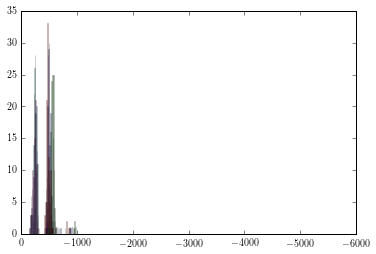

In [18]:
xstart=0
xend=-6000

n, bins, patches=plt.hist(p1_list, 50, normed=0, alpha=0.2)
n, bins, patches=plt.hist(p2_list, 50, normed=0, alpha=0.2)
n, bins, patches=plt.hist(p3_list, 50, normed=0, alpha=0.2)
n, bins, patches=plt.hist(p4_list, 50, normed=0, alpha=0.2)
n, bins, patches=plt.hist(p5_list, 50, normed=0, alpha=0.2)
plt.xlim(xstart, xend)
plt.show()

## Plot Kernel density estimation of peaks/anti-peaks

In [33]:
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

In [34]:
p0_list=[]
p1_list=[]
p2_list=[]
p3_list=[]
p4_list=[]

for event in events:
    try:
        p0_list.append(event._baseline_avg-event._data[event._extrema[0],1])
        p1_list.append(event._baseline_avg-event._data[event._extrema[1],1])
        p2_list.append(event._baseline_avg-event._data[event._extrema[2],1])
        p3_list.append(event._baseline_avg-event._data[event._extrema[3],1])
        p4_list.append(event._baseline_avg-event._data[event._extrema[4],1])
        
    except:
        continue
        

p0_list=np.array(p0_list).reshape(-1,1)
p1_list=np.array(p1_list).reshape(-1,1)
p2_list=np.array(p2_list).reshape(-1,1)
p3_list=np.array(p3_list).reshape(-1,1)
p4_list=np.array(p4_list).reshape(-1,1)



xlow=0
xhigh=max(p0_list+p1_list+p2_list+p3_list+p4_list)
points=10000
xs=np.array([xlow+i*(xhigh-xlow)/points for i in range(points)]).reshape(-1,1)

In [35]:
c=['blue','orange','green','red','magenta']

In [36]:
rand_list=np.random.randint(low=0, high=len(events), size=100).tolist()

In [75]:
title_size=24
axislabel_size=20
legendtitle_size=18
axistick_size=14
legendtext_size=16

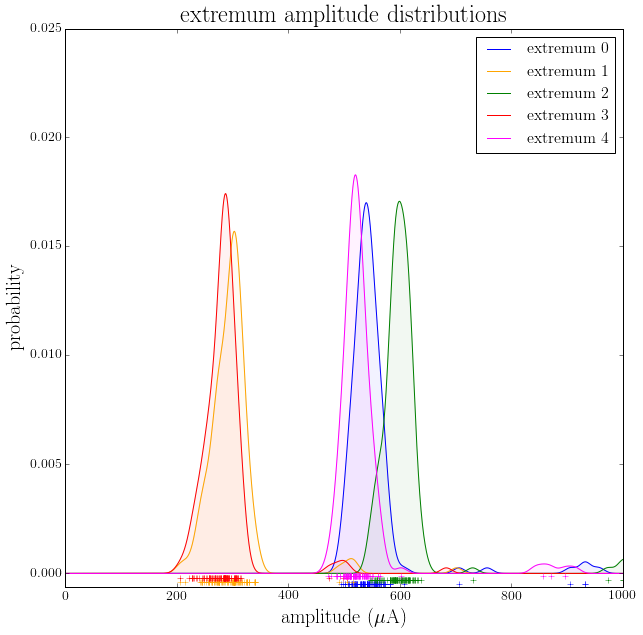

In [40]:
bandwidth=10.
fig=plt.figure(figsize=(10,10))

for i, p_list in enumerate([p0_list, p1_list, p2_list, p3_list, p4_list]):
    kde=KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(p_list)
    log_dens=kde.score_samples(xs)
    plt.plot(xs, np.exp(log_dens), c = c[i], label='extremum '+str(i))
    plt.fill(xs, np.exp(log_dens), fc=c[i], alpha=0.05)
    
    
    
p0_subset=[]
p1_subset=[]
p2_subset=[]
p3_subset=[]
p4_subset=[]
for i in rand_list:
    p0_subset.append(p0_list[i])
    p1_subset.append(p1_list[i])
    p2_subset.append(p2_list[i])
    p3_subset.append(p3_list[i])
    p4_subset.append(p4_list[i])
    
plt.plot(p0_subset,\
         np.zeros(len(p0_subset)) - 0.0005 + .0001*0, '+k', c = c[0])
plt.plot(p1_subset,\
         np.zeros(len(p1_subset)) - 0.0005 + .0001*1, '+k', c = c[1])
plt.plot(p2_subset,\
         np.zeros(len(p2_subset)) - 0.0005 + .0001*2, '+k', c = c[2])
plt.plot(p3_subset,\
         np.zeros(len(p3_subset)) - 0.0005 + .0001*3, '+k', c = c[3])
plt.plot(p4_subset,\
         np.zeros(len(p4_subset)) - 0.0005 + .0001*4, '+k', c = c[4])
    
plt.xlim(0, 1000)
plt.ylim(-.0006, .025)

plt.tick_params(axis='both', which='major', labelsize=axistick_size)
plt.tick_params(axis='both', which='minor', labelsize=axistick_size)

plt.title('extremum amplitude distributions', size=title_size)
plt.ylabel('probability', size=axislabel_size)
plt.xlabel(r'amplitude ($\mu$A)', size=axislabel_size)
plt.legend(loc='upper right', fontsize=legend_size)
plt.savefig('20um_peak_distributions.png', dpi=300)
plt.show()

# Peak fractions

### HCT-116:
    - Chip4_HCT116_0021_0.005
        - [0.83828975348756851, 0.49879334818146326, 1.0, 0.50353118248220341, 0.90134808144913603] [0.18673415792198006, 0.091534369666284268, 0.0, 0.090690073463094087, 0.18754554732119016] (avg, std)
        
### 20 um:
    - Chip4_20um_100mM_KCl_pH8_01_flow_0010
        [0.90599419910237966, 0.4902045203483148, 1.0, 0.46972675833364119, 0.87382647062521845] [0.03673276809944926, 0.043835395872859909, 0.0, 0.040748840779426837, 0.030427783064074877]  

In [41]:
peak_fraction_list=[]
peak_fraction_avg=[0 for i in range(5)]
peak_fraction_std=[0 for i in range(5)]
for j in range(0,5):
    peak_fraction_list=[]
    for i in range(len(events)):
        event=events[i]
        pt0=event._data[event._extrema[j],1]-event._baseline_avg
        pt1=event._data[event._extrema[2],1]-event._baseline_avg
        peak_fraction_list.append(1.*pt0/pt1)
        
    peak_fraction_avg[j]=np.array(peak_fraction_list).mean()
    peak_fraction_std[j]=np.array(peak_fraction_list).std()

In [42]:
print peak_fraction_avg, peak_fraction_std

[0.90599419910237966, 0.4902045203483148, 1.0, 0.46972675833364119, 0.87382647062521845] [0.03673276809944926, 0.043835395872859909, 0.0, 0.040748840779426837, 0.030427783064074877]


In [48]:
hct_avg=[.838, .499, 1.00, .504, .901]
hct_std=[0.187, 0.092, 0.00, 0.091, 0.188]
p20um_avg=[.906, .490, 1.00, .470, .874]
p20um_std=[0.037, 0.044, 0.00, 0.041, 0.030]

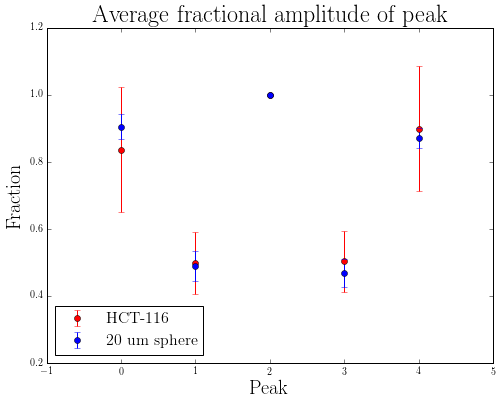

In [77]:
fig=plt.figure(figsize=(8,6))

plt.errorbar([i for i in range(5)], hct_avg, yerr=hct_std, c=(1,0,0), fmt='o', label='HCT-116')
plt.errorbar([i for i in range(5)], p20um_avg, yerr=p20um_std, c=(0,0,1), fmt='o', label=r'20 um sphere')

plt.xlim(-1,5)
plt.ylim(0.2,1.2)

plt.title('Average fractional amplitude of peak', size=title_size)
plt.legend(loc='lower left', numpoints=1, fontsize=legendtext_size)
plt.xlabel('Peak', size=axislabel_size)
plt.ylabel('Fraction', size=axislabel_size)

plt.savefig('peak_fractions.png', dpi=300)

plt.show()

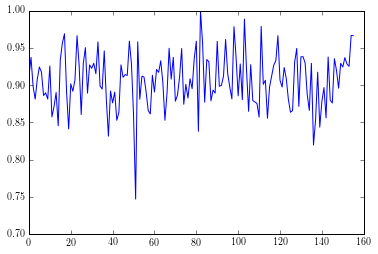

In [79]:
peak_fraction_list=[]
peak_fraction_avg=[0 for i in range(5)]
peak_fraction_std=[0 for i in range(5)]
peak_fraction_list=[]
for i in range(len(events)):
    event=events[i]        
    pt0=event._data[event._extrema[0],1]-event._baseline_avg
    pt1=event._data[event._extrema[2],1]-event._baseline_avg
    peak_fraction_list.append(1.*pt0/pt1)
        
plt.plot(peak_fraction_list)
plt.show()